In [ ]:
# This tests out methodology for doing PCA decomposition and dimensionality
# reduction of empirical data with SVD

# Created 2021 Sept. 18 by E.S.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import linalg

%matplotlib inline

In [30]:
# return number of PCA components that explain X amount of variance
# (note number can be a decimal)

def num_comps_var(variance_expl,variance_target):
    '''
    INPUTS: 
    variance_expl: the cumulative explained variance
    variance_target: the variance we want to account for (decimal)
    
    OUTPUTS:
    comps_interp: the number of modes (will be a decimal interpolation, 
        to allow user to decide whether to round up or down)
    '''

    # abcissa (number of components); start with 1
    abcissa = np.add(1.,np.arange(len(variance_expl)))

    # interpolate (note a flipping of axes is necessary)
    comps_interp = np.interp(x=variance_target,xp=variance_expl,fp=abcissa)

    return comps_interp

In [2]:
time_series = pd.read_csv("test_time_series_20210917.csv", index_col=0)

In [3]:
# make list of brightest stars (and exclude colums with other data)

list_brightest = [] # initialize list of brightest stars
for (columnName, columnData) in time_series.iteritems():
    #print(type(columnData[0]))
    if (columnName != "fit_file_name" and columnName != "jd-2459431" and columnName != "jd_helio-2459431"):
        if (np.median(columnData.values) > 5000):
            #plt.plot(columnData.values)
            #plt.annotate(str(columnName), xy=(2300,np.median(columnData.values)), xycoords="data")
            list_brightest.append(str(columnName))

In [ ]:
# option to remove any stars that may be intrinsically variable

#list_brightest.remove("25")
#list_brightest.remove("271")

In [ ]:
# select the bright stars we want, and whiten the data
# (note that this data subset is not a DataFrame, and 
# we access columns by location)

# separate out the photometry from the brightest stars
x = time_series.loc[:, list_brightest].values

In [ ]:
## BEGIN OPTION TO INJECT FAKE TRANSIT

'''
# column number to inject fake transit into
col_fake_transit = 10

abcissa_time = time_series["jd-2459431"]
# generate transit model
tm = QuadraticModel()
tm.set_data(abcissa_time)
# note t0 is time-of-center
# (k=0.1 gives transit depth of approx 1%)
model_transit = tm.evaluate(k=0.1, ldc=[0.2, 0.1], t0=0.6, p=0.7, a=3.0, i=0.5*np.pi)
noisy_transit = np.multiply(x[:,col_fake_transit],model_transit)

# a scaling of the model to guide the eye on plot
transit_fyi_visual = np.multiply(0.5*np.median(x[:,col_fake_transit]),model_transit)

# replace real photometry with fake
x[:,col_fake_transit] = noisy_transit
'''

## END OPTION TO INJECT FAKE TRANSIT

In [ ]:
# plot to show transits

'''
plt.plot(abcissa_time,time_series["121"],label="original")
plt.plot(abcissa_time,noisy_transit,label="transit")
plt.plot(abcissa_time,transit_visual, linestyle="--", color="k")
plt.legend()
plt.show()
'''

In [4]:
# standardize the photometry (i.e., whiten the data)
scaler = StandardScaler() # this conveniently let us retrieve attributes (mean, offset) for reconstruction
x_scaled = scaler.fit_transform(x) # whiten

In [5]:
# decompose with SVD

U, s, Vh = linalg.svd(x_scaled)

# turn s into the full sigma matrix
sigma = np.zeros((U.shape[0], Vh.shape[0]))
for i in range(min(U.shape[0], Vh.shape[0])):
    sigma[i, i] = s[i]

In [28]:
# determine cumulative explained variance

# note the diagonal values in the sigma matrix are the 
# 'singular values', or the square roots of the eigenvalues 
# of x_scaled.T*x_scaled; they are squared to show the contribution
# of that mode to the variance

variance_explained = []
eigen_vals = np.power(s,2.)
for i in eigen_vals:
    variance_explained.append((i/sum(eigen_vals)))

cumulative_variance_explained = np.cumsum(variance_explained)

In [33]:
test = num_comps_var(variance_expl=cumulative_variance_explained,variance_target=0.99)

In [34]:
## ## USER DECISIONS HERE

33.49363253386655

In [6]:
# reconstruct original matrix ON LOWER DIMS

N = 20 # modes to keep

x_scaled_lower = np.dot(U, np.dot(sigma[:,:N], Vh[:N,:]))

In [20]:
# de-trend the photometry of ALL the stars by subtracting the lower-dim reconstruction
# (note this photometry has not been reverse-whitened yet)

photometry_detrend_white = np.subtract(x_scaled,x_scaled_lower)

In [23]:
# make full PCA-reconstruction, based on lower-dimensional basis set, 
# by reverse-whitening (up until now we have only PCA-reconstructed 
# the whitened data)

# note the same functionality is in .inverse_transform(), but the below
# is clearer to me

# test to see we get same as original
x_recon_exact = np.add(np.multiply(x_scaled,scaler.scale_),scaler.mean_)
# from lower-dim basis set, but without having done de-trending
x_recon_lower = np.add(np.multiply(x_scaled_lower,scaler.scale_),scaler.mean_)
# with detrending
x_recon_detrend = np.add(np.multiply(photometry_detrend_white,scaler.scale_),scaler.mean_)

# choose one detrended star
col_to_use = 27
x_recon_detrend_one = x_recon_detrend[:,col_to_use]

#scaler.mean_
#x_scaled = StandardScaler().fit_transform(x)

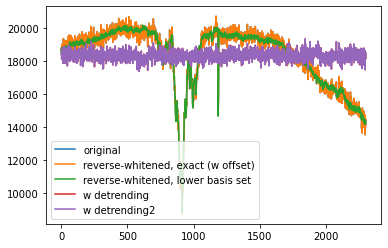

In [24]:
# fyi plots

'''
plt.plot(x[:,col_to_use], label="original")
plt.plot(np.subtract(x_recon_exact[:,col_to_use],0), label="reverse-whitened, exact (w offset)")
plt.plot(x_recon_lower[:,col_to_use], label="reverse-whitened, lower basis set")
plt.plot(x_recon_detrend[:,col_to_use], label="w detrending")
plt.legend()
plt.show()
'''